<a href="https://colab.research.google.com/github/rassuncao/DL2021-Unsupervised/blob/main/Extreme_Autoencoder_CNN_Functional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extreme Autoencoder: usando um code de dimensão 2

Neste notebook, vamos usar uma representação extremamente simples das imagens do MNIST via autoencoders. Queremos usar um CODE de dimensão 2. Vamos criar uma CNN com a API functional  para explorar como a representação com um CODE=(c_1, c_2) de diemnsão 2 representa os diversos dígitos. 

Em particular, nosso objetivo é gerar o gráfico abaixo. Cada ponto representa uma imagem do conjunto de teste do MNIST. Os eixos coordenados representam as duas dimensões do CODE (c_1 e c_2). As cores mostram as diferentes classes de dígitos (0,1,2,...,9). Lembre-se que essas classes não foram usadas para treinar o autoencoder.  

Apesar de não usar as classes, o autoencoder foi capaz de gerar um CODE bi-dimensional que cria clusters naturais dos diferentes dígitos. Isto é, na representação do CODE=(c_1, c_2) dígitos da classe 7 aparecem naturalmente agrupados numa região do plano (c_1, c_2) enquanto que dígitos da classe 3 aparecem naturalmente agrupados em outra região. 

Para criar este gráfico, não basta termos apenas a saída final do autoencoder (a recuperação da imagem na entrada na forma de uma outra imagem na saída). Nós precisamos fazer uso do CODE bi-dimensional gerado no meio do autoencoder. Isto mostra a vantagem do uso da API funcional do Keras para definir diferentes layers (e modelos) que sejam sub-redes da rede autoeconcoder.

In [ ]:
from keras.models import Model
from keras.layers import Conv2D, Dense, Flatten, Reshape
from keras.layers import MaxPooling2D, Dropout, UpSampling2D
from keras.datasets import mnist
import keras
import numpy as np
import matplotlib.pyplot as plt 

In [ ]:
# Load mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Scale images to the interval [0,1]
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train = x_train.reshape((len(x_train), 28, 28, 1))
x_test = x_test.reshape((len(x_test), 28, 28, 1)) 

print(f'x_train shape = {x_train.shape}')
print(f'x_test shape = {x_test.shape}')

x_train shape = (60000, 28, 28, 1)
x_test shape = (10000, 28, 28, 1)


In [ ]:
# Especificando o modelo

input_img = keras.Input(shape=(28, 28, 1))

x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(input_img)
# Output Shape = (28, 28, 16)  
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
# Output Shape = (14, 14, 16)  
x = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(x)
# Output Shape = (14, 14, 8)  
x = MaxPooling2D((2, 2), padding='same')(x)
# Output Shape = (7, 7, 8)  
x = Conv2D(filters=2, kernel_size=(3, 3), activation='relu', padding='same')(x)
# Output Shape = (7, 7, 2)  

# Tranformando num array uni-dimensional
x = Flatten()(x)
# Output Shape = (98, )  

# finalmente, nós definimos um Layer object que contém toda a arquitetura do encoder
encoded = Dense(2, activation='relu')(x) 
# Output Shape = (2, )  

# Agora, definimos um Keras Model do encoder sua rede e inputs e outputs adequados
encoder = Model(input_img, encoded)

# Construímos uma sequência de camadas para obter a camada decoder
# cujo output shape deve ser (28, 28, 1) 
# Partimos da camada encoded  
x = Dense(98, activation='relu')(encoded)
# Output Shape = (98, )  
x = Reshape((7, 7, 2))(x)
# Output Shape = (7, 7, 2)  

x = UpSampling2D((2, 2))(x)  
# Output Shape = (14, 14, 2)

x = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(x)
# Output Shape = (14, 14, 8)
x = UpSampling2D((2, 2))(x)
# Output Shape = (28, 28, 8)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
# Output Shape = (28, 28, 16)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
# Output Shape = (28, 28, 1)

# Create the decoder model
decoder = Model(encoded, decoded)

# Create the autoencoder model
autoencoder = Model(input_img, decoded)
print("autoencoder summary:  " , autoencoder.summary())
print("autoencoder summary:  " , encoder.summary())
print("autoencoder summary:  " , decoder.summary())


Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 7, 7, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 7, 7, 2)           146

In [ ]:
# This is our encoded (32-dimensional) input
#encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
#decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = Model(encoded, decoded)

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(x_train, x_train, batch_size=32, epochs=50)

# Pode usar 15 epochs pois 50 epochs demora muito e a loss não diminui quase nada depois de 15 epochs.
# A reconstrução do decoder não será muito boa pois usamos um code com dimensão muito pequena (dim = 2) 

Epoch 1/50
1875/1875 [==============================] - 105s 55ms/step - loss: 0.2464
Epoch 2/50
1875/1875 [==============================] - 104s 55ms/step - loss: 0.2187
Epoch 3/50
1875/1875 [==============================] - 104s 55ms/step - loss: 0.2155
Epoch 4/50
1875/1875 [==============================] - 103s 55ms/step - loss: 0.2138
Epoch 5/50
1875/1875 [==============================] - 103s 55ms/step - loss: 0.2127
Epoch 6/50
1875/1875 [==============================] - 105s 56ms/step - loss: 0.2119
Epoch 7/50
1875/1875 [==============================] - 109s 58ms/step - loss: 0.2112
Epoch 8/50
1875/1875 [==============================] - 108s 58ms/step - loss: 0.2107
Epoch 9/50
1875/1875 [==============================] - 107s 57ms/step - loss: 0.2103
Epoch 10/50
1875/1875 [==============================] - 108s 58ms/step - loss: 0.2099
Epoch 11/50
1875/1875 [==============================] - 114s 61ms/step - loss: 0.2095
Epoch 12/50
1875/1875 [=============================

In [ ]:
out_imgs = autoencoder.predict(x_test)

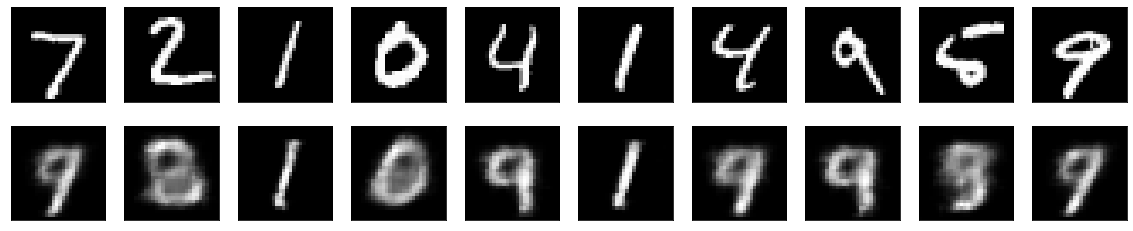

In [ ]:
# Visualizando algumas entradas do conjunto de teste e a representação através 
# do autoencoder

n = 10
plt.figure(figsize=(20,4))

for i in range(n):
  ax = plt.subplot(2, n, i+1) # 10 plots na primeira linha 
  plt.imshow(x_test[i].reshape(28, 28)) # mostrando como imagem
  plt.gray()
  ax.get_xaxis().set_visible(False) # omitindo os eixos coordenados
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i+1+n) # 10 plots na segunda linha 
  plt.imshow(out_imgs[i].reshape(28,28)) # usando as reconstruções 
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  
plt.show()

In [ ]:
code_test = encoder.predict(x_test)

<class 'numpy.ndarray'>
(10000, 2)


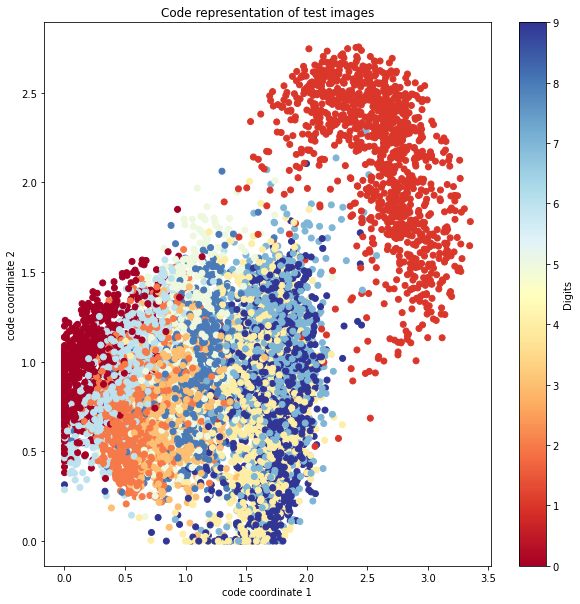

In [ ]:
print(type(code_test))
print(code_test.shape)

plt.figure(figsize=(10,10))
cm = plt.cm.get_cmap('RdYlBu')
plt.scatter(code_test[:, 0], code_test[:, 1], c=y_test, cmap=cm)
plt.title("Code representation of test images")
plt.xlabel("code coordinate 1")
plt.ylabel("code coordinate 2")
cbar = plt.colorbar()
cbar.set_label("Digits")
plt.show()